In [1]:
# Data Manipulation.
import pandas as pd
import numpy as np

# Data Visualization.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Dimencionality Reduction.
from sklearn.decomposition import PCA

# Imputer 
from sklearn.impute import KNNImputer

# Data Standardization.
from sklearn.preprocessing import RobustScaler

# DS Division.
from sklearn.model_selection import train_test_split

# Data Balancing.
from imblearn.over_sampling import SMOTE

# Search Hyperparameters.
from sklearn.model_selection import GridSearchCV

# Classifier Models.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Precision Metrics.
from sklearn.metrics import f1_score

# Save Models.
from joblib import dump, load

# Warnings.
import warnings
warnings.filterwarnings("ignore")

# Time.
import time

# Color Palette.
palette = sns.husl_palette(h=.5)
palette_matrix = sns.color_palette("light:#5A9", as_cmap=True)

In [2]:
# 1. Create a DF with the revision of the data (value count, type, null, infinity).
def df_revision(df):
    col_values_count = {i:df[i].value_counts().shape[0] for i in df.columns}
    col_dtype = {i:df[i].dtype for i in df.columns}
    col_isObj = {i:('🟢' if df[i].dtype in ['object', 'string'] else '-') for i in df.columns}
    col_na = {i:('🔴' if df[i].isna().any() == True else '-') for i in df.columns}
    col_inf = {i:('🔴' if df[i].isin([np.inf, - np.inf]).any() == True else '-') for i in df.columns}
    df_revision = pd.DataFrame([col_values_count, col_dtype, col_isObj, col_na, col_inf], index=['Values_Count', 'DType','Is_Obj', 'NA', 'inf']).transpose()
    return df_revision


# 2. Divide the DF into the set of Training, Validation and Test.
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)


# 3. Remove Target (Separates the Label from the Features)
def remove_labels(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name].copy()
    return (X, y)


# 4. Search Model
def search_model(names, models, X_train, y_train, X_val, y_val, X_test, y_test, pos_label):
    f1_Vali = []
    f1_Test = []
    fitting = []
    times = []

    for clf in models:
    
    # ======= TRAIN ========
      start = time.time()
      clf.fit(X_train, y_train.values.ravel())
      end = time.time()
      times.append(round(end - start, 3))

    # ===== VALIDATION =====
      y_val_pred = clf.predict(X_val)
      f1_val = f1_score(y_val, y_val_pred, pos_label=pos_label)

    # ======= TEST ========
      y_test_pred = clf.predict(X_test)
      f1_test = f1_score(y_test, y_test_pred, pos_label=pos_label)

    # ======= SCORE =======
      f1_Vali.append(round(f1_val*100, 3))
      f1_Test.append(round(f1_test*100, 3))
      fitting.append(round((f1_val - f1_test)*100, 3))

    df_models = pd.DataFrame([f1_Vali, f1_Test, fitting, times], columns=names, index=['F1 Vali', 'F1 Test', 'Fitting', 'Seconds'])
    df_models = df_models.sort_values(by = ['F1 Vali', 'F1 Test', 'Seconds', 'Fitting'], axis=1, ascending=False)
    
    return df_models


# 5. Top Features Ranking DF
def top_features(X_train, y_train, s_X_train, s_y_train):

    # Top Features
    rank_f_model = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    rank_f_model.fit(X_train, y_train)
    rank = rank_f_model.feature_importances_
    rank_ls = {name: score for name, score in zip(list(X_train), rank)}
    top = pd.Series(rank_ls).sort_values(ascending=False)

    # Top Features Standarized
    s_rank_f_model = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    s_rank_f_model.fit(s_X_train, s_y_train)
    s_rank = s_rank_f_model.feature_importances_
    s_rank_ls = {name: score for name, score in zip(list(s_X_train), s_rank)}
    s_top = pd.Series(s_rank_ls).sort_values(ascending=False)


    df_rank_f  = pd.DataFrame([top.index, top.values, s_top.index, s_top.values],
                                   index=['Features', "Value", "Features Standardized", "Values S"]).T
    return df_rank_f

In [4]:
# The data is converted to a dataframe.
df_original = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Main dataframe is created.
df = df_original.copy()

# Dataframe is created for EDA (Assumptions).
df_eda = df_original.copy()

# Dataframe is created for Modeling
df_m = df_original.copy()

In [6]:
# Show DF.
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# Statistical information is obtained.
df.describe(include='all').fillna('-').round(1)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.0,5110,5110.0,5110.0,5110.0,5110,5110,5110,5110.0,4909.0,5110,5110.0
unique,-,3,-,-,-,2,5,2,-,-,4,-
top,-,Female,-,-,-,Yes,Private,Urban,-,-,never smoked,-
freq,-,2994,-,-,-,3353,2925,2596,-,-,1892,-
mean,36517.829354,-,43.226614,0.097456,0.054012,-,-,-,106.147677,28.893237,-,0.048728
std,21161.721625,-,22.612647,0.296607,0.226063,-,-,-,45.28356,7.854067,-,0.21532
min,67.0,-,0.08,0.0,0.0,-,-,-,55.12,10.3,-,0.0
25%,17741.25,-,25.0,0.0,0.0,-,-,-,77.245,23.5,-,0.0
50%,36932.0,-,45.0,0.0,0.0,-,-,-,91.885,28.1,-,0.0
75%,54682.0,-,61.0,0.0,0.0,-,-,-,114.09,33.1,-,0.0


In [8]:
# The characteristics of the DF features are reviewed (Auxiliary Function is used).
df_revision(df)

,Values_Count,DType,Is_Obj,NA,inf
id,5110,int64,-,-,-
gender,3,object,🟢,-,-
age,104,float64,-,-,-
hypertension,2,int64,-,-,-
heart_disease,2,int64,-,-,-
ever_married,2,object,🟢,-,-
work_type,5,object,🟢,-,-
Residence_type,2,object,🟢,-,-
avg_glucose_level,3979,float64,-,-,-
bmi,418,float64,-,🔴,-


In [9]:
# Gets the names of the categorical features.
features_cat = df.select_dtypes(include=('object')).columns

# The features with categories of a size smaller than 5% of the data are obtained.
for i in features_cat:
    count = round(df[i].value_counts() / len(df) * 100, 2)
    for j in count:
        if j < 3:
            print(f"\nSize in % of Categories in {i}:\n{count}\n")


Size in % of Categories in gender:
gender
Female    58.59
Male      41.39
Other      0.02
Name: count, dtype: float64


Size in % of Categories in work_type:
work_type
Private          57.24
Self-employed    16.03
children         13.44
Govt_job         12.86
Never_worked      0.43
Name: count, dtype: float64


In [10]:
# Dataframe with count of Target values.
stroke_count = pd.DataFrame(df['stroke'].value_counts()).rename({'stroke':'# Count'}, axis=1)
stroke_percent = ((pd.DataFrame(df['stroke'].value_counts())/len(df))*100).round(2).rename({'stroke':'% Percentage'}, axis=1)

# Target Value Count DataFrame is created.
stroke = pd.concat([stroke_count, stroke_percent], axis=1)
stroke

,count,count
stroke,,
0,4861,95.13
1,249,4.87


In [11]:
# Delete of feature "id".
df = df.drop('id', axis=1)

In [12]:
# The NA in the 'bmi' feature are reviewed.
bmi_na = df['bmi'].isna().sum()

# Get the Median of the feature 'bmi'.
bmi_str = df['bmi'].std().round(2)

# Get the Median of the feature 'bmi'.
bmi_median = df['bmi'].median().round(2)

# We fill NA of the feature 'bmi' with the median of its values.
df['bmi'] = df['bmi'].fillna(bmi_median)

print("\n'bmi' NA count: ", bmi_na)
print("'bmi' Str : ", bmi_str)
print("'bmi' Median : ", bmi_median)
print("'bmi' NA count after fill: ", df['bmi'].isna().sum())


'bmi' NA count:  201
'bmi' Str :  7.85
'bmi' Median :  28.1
'bmi' NA count after fill:  0


In [13]:
# DF for Encode.
df_encode = df

# Get the features of type object.
cat_encode = df_encode.select_dtypes(include='object').columns

# Remove Noisy Feature.
df_encode = df_encode.drop(df_encode.loc[df_encode['gender']=='Other'].index)

# Object type Features are Coded.
df_encode = pd.get_dummies(df_encode, columns=cat_encode, prefix_sep='_', drop_first=True)
df_encode.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,28.1,1,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.5,1,True,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.4,1,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.0,1,False,True,False,False,True,False,False,False,True,False


In [14]:
# Encode Features of DataFrame without Label.
features_encode = df_encode.drop(['stroke'], axis=1)

# Principal Component Analysis (PCA) is instantiated to transform the features to 2 main features.
pca = PCA(n_components=2)
df_pca = pca.fit_transform(features_encode)

# A DF is created with the result of the transformation.
df_pca = pd.DataFrame(df_pca, columns=['feature_1','feature_2'])

# A DF is created with the result of the transformation.
df_reduce = pd.concat([df_pca, df['stroke']], axis=1)

# It is obtained that both the variance was preserved.
variance = ((pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100).round(2)
print(f"\nAfter PCA the variance for each feature was preserved in a: {variance}%\n")
print(df_reduce.head())


After PCA the variance for each feature was preserved in a: 97.96%

    feature_1  feature_2  stroke
0  124.935302  -5.008124       1
1   97.583581  -2.326622       1
2    5.557918 -36.526612       1
3   65.348130   3.908459       1
4   72.478943 -23.937300       1


ValueError: The following variable cannot be assigned with wide-form data: `hue`

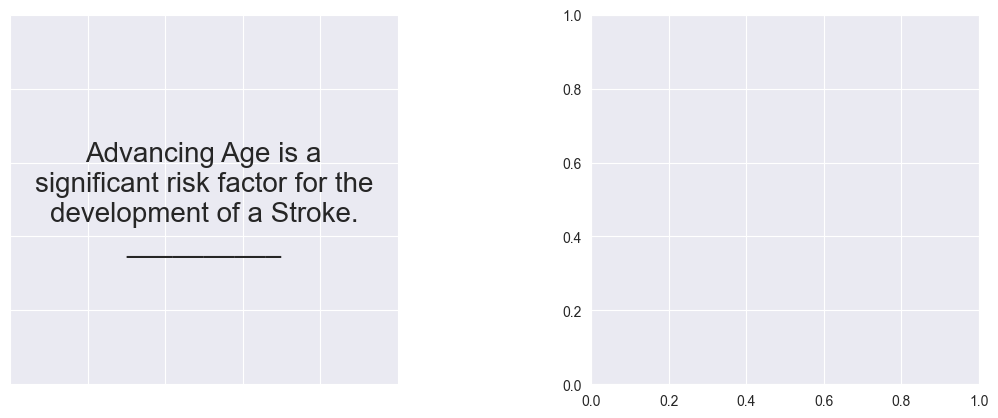

In [15]:
# DF of patients categorized by age range.
df_eda['age_range'] = pd.cut(df_eda['age'], bins=[0, 46, 65, np.inf], include_lowest=True,
                             labels=["Youth\n(0 - 45)", "Adulthood\n(46 - 64)", "Old Age\n(65 - )"])

df_eda['old_age'] = pd.cut(df_eda['age'], bins=[0, 46, np.inf], include_lowest=True,
                             labels=["Youth", "Adulthood & Old Age"])

# Adulthood & Old Age.
adul_old = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age") & (df_eda['stroke'] == 0)])
adul_old_stroke = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age") & (df_eda['stroke'] == 1)])
adul_old_total = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age")])
adul_old = round((adul_old / adul_old_total) * 100, 2)
adul_old_stroke = round((adul_old_stroke / adul_old_total) * 100, 2)
patients_adul_old = [adul_old, adul_old_stroke]

# Youth.
youth = len(df_eda.loc[(df_eda['age_range'] == "Youth\n(0 - 45)") & (df_eda['stroke'] == 0)])
youth_stroke = len(df_eda.loc[(df_eda['age_range'] == "Youth\n(0 - 45)") & (df_eda['stroke'] == 1)])
youth_total = len(df_eda.loc[(df_eda['age_range'] == "Youth\n(0 - 45)")])
youth = round((youth / youth_total) * 100, 2)
youth_stroke = round((youth_stroke / youth_total) * 100, 2)
patients_youth = [youth, youth_stroke]

# Adulthood.
adul = len(df_eda.loc[(df_eda['age_range'] == "Adulthood\n(46 - 64)") & (df_eda['stroke'] == 0)])
adul_stroke = len(df_eda.loc[(df_eda['age_range'] == "Adulthood\n(46 - 64)") & (df_eda['stroke'] == 1)])
adul_total = len(df_eda.loc[(df_eda['age_range'] == "Adulthood\n(46 - 64)")])
adul = round((adul / adul_total) * 100, 2)
adul_stroke = round((adul_stroke / adul_total) * 100, 2)
patients_adul = [adul, adul_stroke]

# Old Age.
old = len(df_eda.loc[(df_eda['age_range'] == "Old Age\n(65 - )") & (df_eda['stroke'] == 0)])
old_stroke = len(df_eda.loc[(df_eda['age_range'] == "Old Age\n(65 - )") & (df_eda['stroke'] == 1)])
old_total = len(df_eda.loc[(df_eda['age_range'] == "Old Age\n(65 - )")])
old = round((old / old_total) * 100, 2)
old_stroke = round((old_stroke / old_total) * 100, 2)
patients_old = [old, old_stroke]

# Plot
fig = plt.figure(figsize=(20,12))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.5, hspace=0.5)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Advancing Age is a\nsignificant risk factor for the\ndevelopment of a Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Age Range.
ax1 = fig.add_subplot(gs[0,1])
ax1 = sns.countplot(df_eda['age_range'], hue=df_eda['stroke'], palette=palette)
ax1.set_title(f"\n\n\nAge Range with the Highest Number\nof Stroke Patients.", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('Years')
ax1.set_ylabel('# Pacients')

# Plot Adul Old.
ax2 = fig.add_subplot(gs[0, 2])
ax2 = plt.pie(patients_adul_old, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("Patients older\nthan 45 years.", fontsize=13)

# Plot Youth.
ax2 = fig.add_subplot(gs[1, 0])
ax2 = plt.pie(patients_youth, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.4], colors = ['#449E95', '#509FCF'])
plt.title("Patients Under\n45 years of age.", fontsize=13)

# Plot Adul.
ax2 = fig.add_subplot(gs[1, 1])
ax2 = plt.pie(patients_adul, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("Adult Patients with an\nAge Between 46 to 65 years.", fontsize=13)

# Plot Old.
ax2 = fig.add_subplot(gs[1, 2])
ax2 = plt.pie(patients_old, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.075, 0], colors = ['#449E95', '#509FCF'])
plt.title("Old Age Patients\nOlder than 65 years.", fontsize=13)

plt.show()

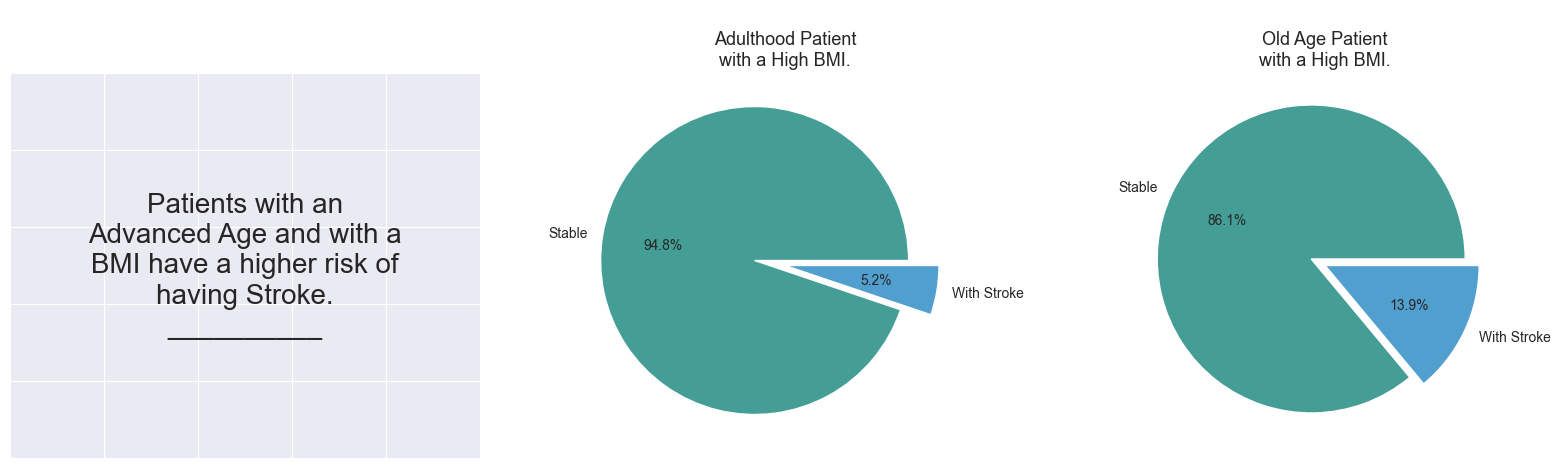

In [16]:
# DF of Patients categorized by their high BMI
df_eda['high BMI'] = pd.cut(df_eda['bmi'], bins=[0, 18.5, 24.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "High BMI"])

# Adulthood.
adul_h_AgeBMI = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
adul_h_AgeBMI_stroke = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
adul_h_AgeBMI_total = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI')])
adul_h_AgeBMI = round((adul_h_AgeBMI / adul_h_AgeBMI_total) * 100, 2)
adul_h_AgeBMI_stroke = round((adul_h_AgeBMI_stroke / adul_h_AgeBMI_total) * 100, 2)
pacients_adul_h_AgeBMI_total = [adul_h_AgeBMI, adul_h_AgeBMI_stroke]

# Old Age.
old_h_AgeBMI = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
old_h_AgeBMI_stroke = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
old_h_AgeBMI_total = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI')])
old_h_AgeBMI = round((old_h_AgeBMI / old_h_AgeBMI_total) * 100, 2)
old_h_AgeBMI_stroke = round((old_h_AgeBMI_stroke / old_h_AgeBMI_total) * 100, 2)
pacients_old_h_AgeBMI = [old_h_AgeBMI, old_h_AgeBMI_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with an\nAdvanced Age and with a\nBMI have a higher risk of\nhaving Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Adulthood.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(pacients_adul_h_AgeBMI_total, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nAdulthood Patient\nwith a High BMI.", fontsize=13)

# Plot Old.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(pacients_old_h_AgeBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nOld Age Patient\nwith a High BMI.", fontsize=13)

plt.show()

ValueError: The following variable cannot be assigned with wide-form data: `hue`

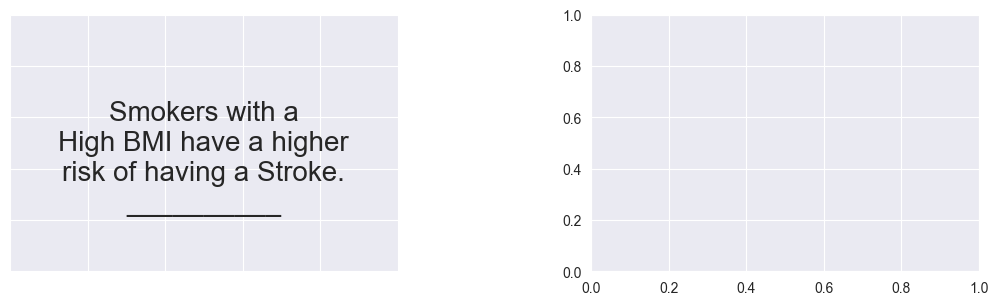

In [17]:
# DF of Patients categorized by their BMI
df_eda['bmi_cat'] = pd.cut(df_eda['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "Weight Above", "Obesity"])                           

# Smoke Status Stroke.
smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'smoke') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
f_smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
no_smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])

# Formerly Smokes.
f_smokes = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
f_smokes_stroke = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
f_smokes_total = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI')])
f_smokes = round((f_smokes / f_smokes_total) * 100, 2)
f_smokes_stroke = round((f_smokes_stroke / f_smokes_total) * 100, 2)
f_smoke_highBMI = [f_smokes, f_smokes_stroke]

# No Smokes.
no_smokes = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
no_smokes_stroke = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
no_smokes_total = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI')])
no_smoke = round((no_smokes / no_smokes_total) * 100, 2)
no_smokes_stroke = round((no_smokes_stroke / no_smokes_total) * 100, 2)
no_smoke_highBMI = [no_smoke, no_smokes_stroke]

# Plots
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.5, hspace=1)

# Plot Title High BMI
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'\nSmokers with a\nHigh BMI have a higher\nrisk of having a Stroke.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot
ax1 = fig.add_subplot(gs[0,1])
ax1 = sns.countplot(df_eda['bmi_cat'], hue=df_eda['stroke'], palette=palette)
ax1.set_title(f"\nBMI of Patients with Stroke\n\n", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('BMI')
ax1.set_ylabel('# Patients')

# Plot Smoke Status Stroke.
ax2 = fig.add_subplot(gs[0,2])
ax2 = plt.pie([smokes_stroke_len,f_smokes_stroke_len, no_smokes_stroke_len], autopct='%1.1f%%', explode=[0, 0.05, 0],
              labels = ['Smoke', 'Formely Smoked', 'Never Smoked'], colors = ['#D37EE3', '#449E95', '#509FCF'])
plt.title("\nSmoking in patients with\nhigh BMI and who have a stroke.\n", fontsize=13)

# Plot Title Smoke
ax3 = fig.add_subplot(gs[1,0])
ax3.text(0.5,0.5,'There are no\nPatients with High BMI\nconsidered Smokers who\nhave had a Stroke.\n',
         fontsize=16, horizontalalignment='center', verticalalignment='center')
ax3.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax3.tick_params(left=False, bottom=False)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Plot Formerly Smokes.
ax4 = fig.add_subplot(gs[1,1])
ax4 = plt.pie(f_smoke_highBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("Patients who\nSmoked with a High BMI.", fontsize=13)

# Plot No Smokes.
ax5 = fig.add_subplot(gs[1,2])
ax5 = plt.pie(no_smoke_highBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("Non-smokers\nwith a High BMI.", fontsize=13)

plt.show()

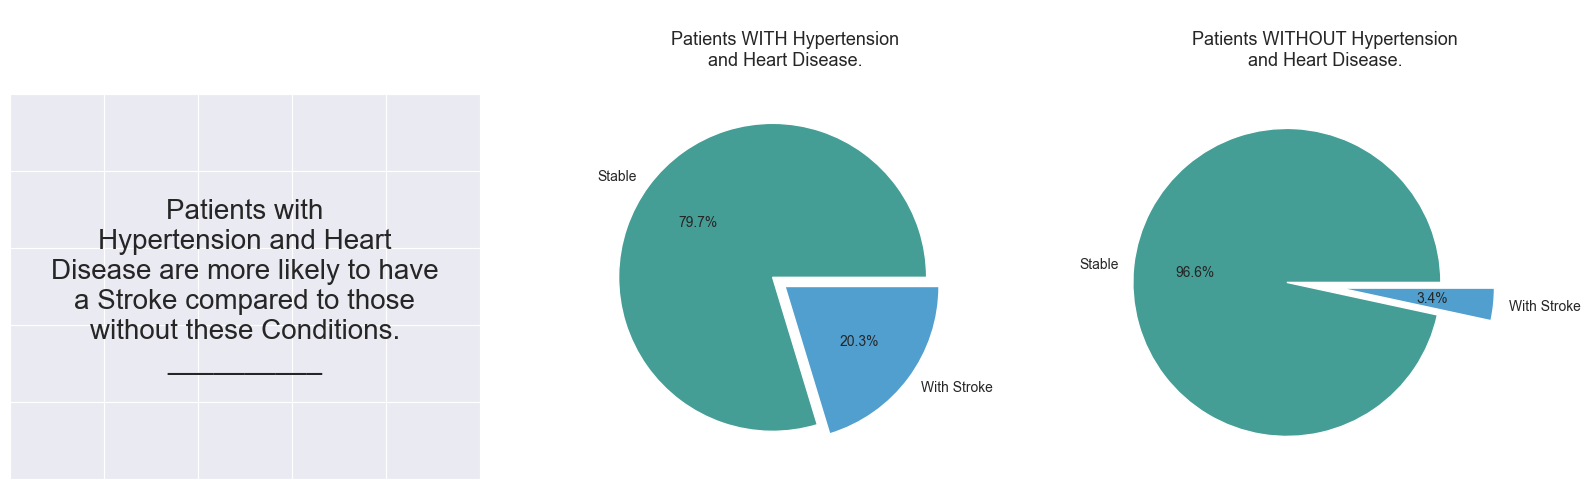

In [18]:
# With.
with_hh = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1) & (df_eda['stroke'] == 0)])
with_hh_stroke = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1) & (df_eda['stroke'] == 1)])
with_hh_total = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1)])
with_hh = round((with_hh / with_hh_total) * 100, 2)
with_hh_stroke = round((with_hh_stroke / with_hh_total) * 100, 2)
patients_with_hh = [with_hh, with_hh_stroke]

# Without.
without_hh = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0) & (df_eda['stroke'] == 0)])
without_hh_stroke = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0) & (df_eda['stroke'] == 1)])
without_hh_total = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0)])
without_hh = round((without_hh / without_hh_total) * 100, 2)
without_hh_stroke = round((without_hh_stroke / without_hh_total) * 100, 2)
patients_without_hh = [without_hh, without_hh_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with\nHypertension and Heart\nDisease are more likely to have\na Stroke compared to those\nwithout these Conditions.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot With.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_with_hh, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients WITH Hypertension\nand Heart Disease.\n", fontsize=13)

# Plot Without.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_without_hh, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.25, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients WITHOUT Hypertension\nand Heart Disease.\n", fontsize=13)

plt.show()

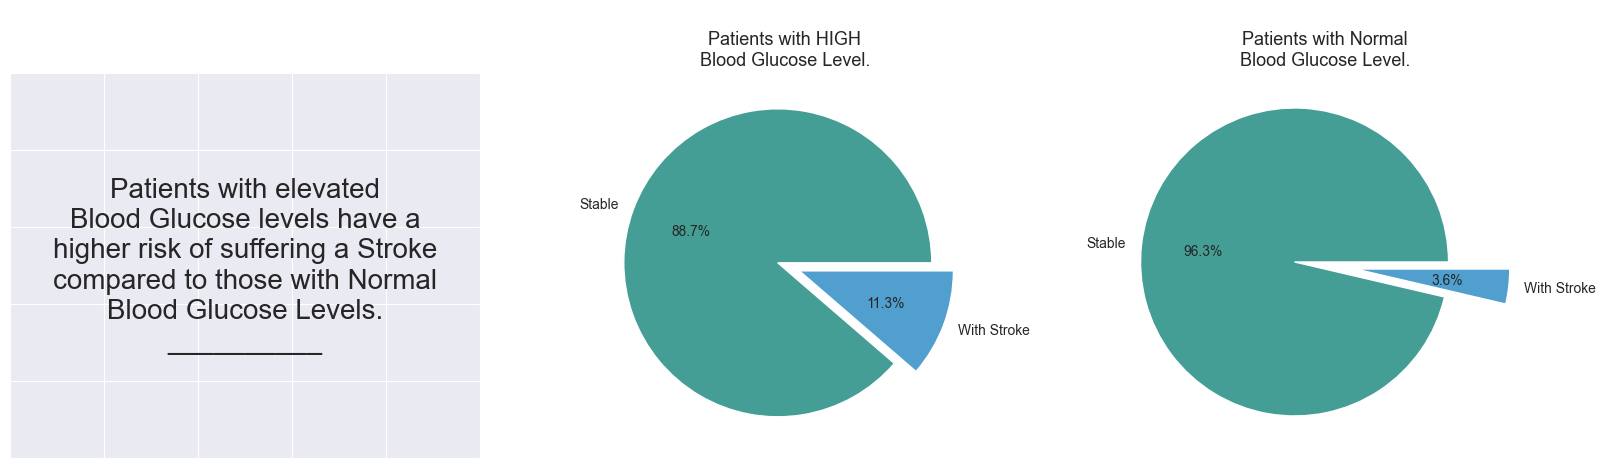

In [19]:
df_eda['avg_gluc_lvl_range'] = pd.cut(df_eda['avg_glucose_level'], bins=[0, 70, 140, np.inf], include_lowest=True,
                                          labels=["Low Level", "Normal Level", "High Level"])

# High. 
high = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level') & (df_eda['stroke'] == 0)])
high_stroke =  len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level') & (df_eda['stroke'] == 1)])
high_total = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level')])
high = round((high / high_total) * 100, 2)
high_stroke = round((high_stroke / high_total) * 100, 2)
patients_high = [high, high_stroke]

# Normal.
normal = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Normal Level') & (df_eda['stroke'] == 0)])
normal_stroke = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Normal Level') & (df_eda['stroke'] == 1)])
normal_total = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Normal Level')])
normal = round((normal / normal_total) * 100, 2)
normal_stroke = round((normal_stroke / normal_total) * 100, 2)
patients_normal = [normal, normal_stroke]

# Plot.
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title.
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with elevated\nBlood Glucose levels have a\nhigher risk of suffering a Stroke\ncompared to those with Normal\nBlood Glucose Levels.\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_high, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.05, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients with HIGH\nBlood Glucose Level.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_normal, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0.2], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients with Normal\nBlood Glucose Level.", fontsize=13)

plt.show()

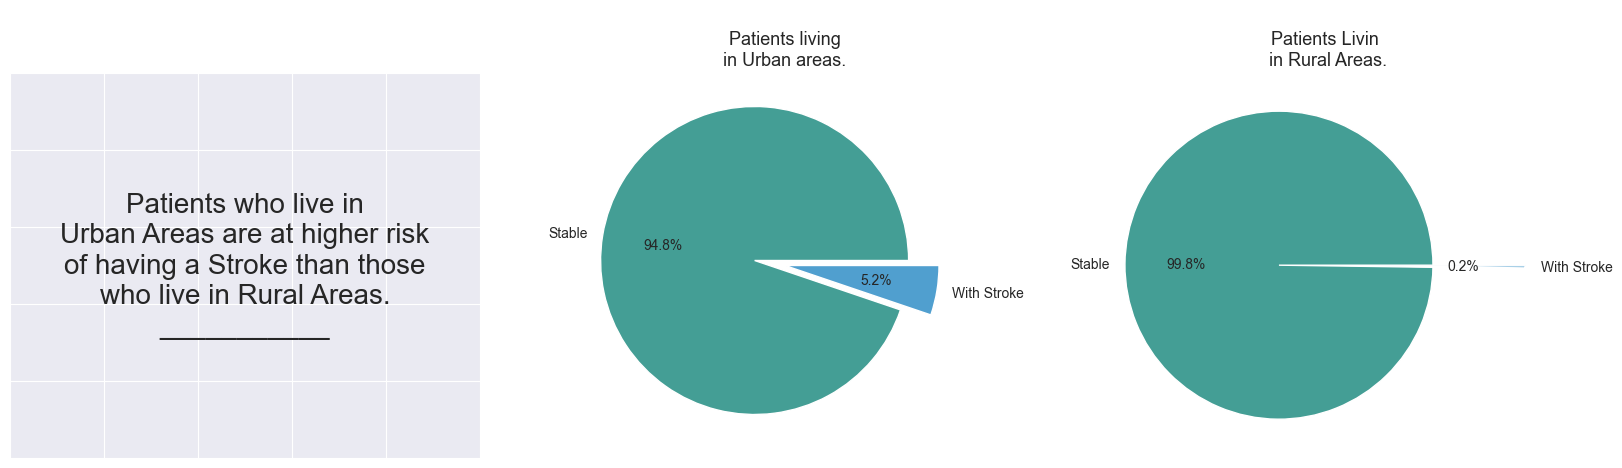

In [20]:
# Urban
urban = len(df_eda.loc[(df_eda['Residence_type'] == 'Urban') & (df_eda['stroke'] == 0)])
urban_stroke =  len(df_eda.loc[(df_eda['Residence_type'] == 'Urban') & (df_eda['stroke'] == 1)])
urban_total = len(df_eda.loc[(df_eda['Residence_type'] == 'Urban')])
urban = round((urban / urban_total) * 100, 2)
urban_stroke = round((urban_stroke / urban_total) * 100, 2)
patients_urban = [urban, urban_stroke]

# Rural
rural = len(df_eda.loc[(df_eda['Residence_type'] == 'Rural') & (df_eda['stroke'] == 0)])
rural_stroke =  len(df_eda.loc[(df_eda['Residence_type'] == 'Rural') & (df_eda['stroke'] == 1)])
rural_total = len(df_eda.loc[(df_eda['Residence_type'] == 'Rural')])
rural = round((rural / rural_total) * 100, 2)
rural_stroke = round((urban_stroke / rural_total) * 100, 2)
patients_rural = [rural, rural_stroke]


# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients who live in\nUrban Areas are at higher risk\nof having a Stroke than those\nwho live in Rural Areas.\n___________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Urban.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_urban, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients living\nin Urban areas.", fontsize=13)

# Plot Rural.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_rural, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.3, 0.3], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients Livin\n in Rural Areas.", fontsize=13)

plt.show()

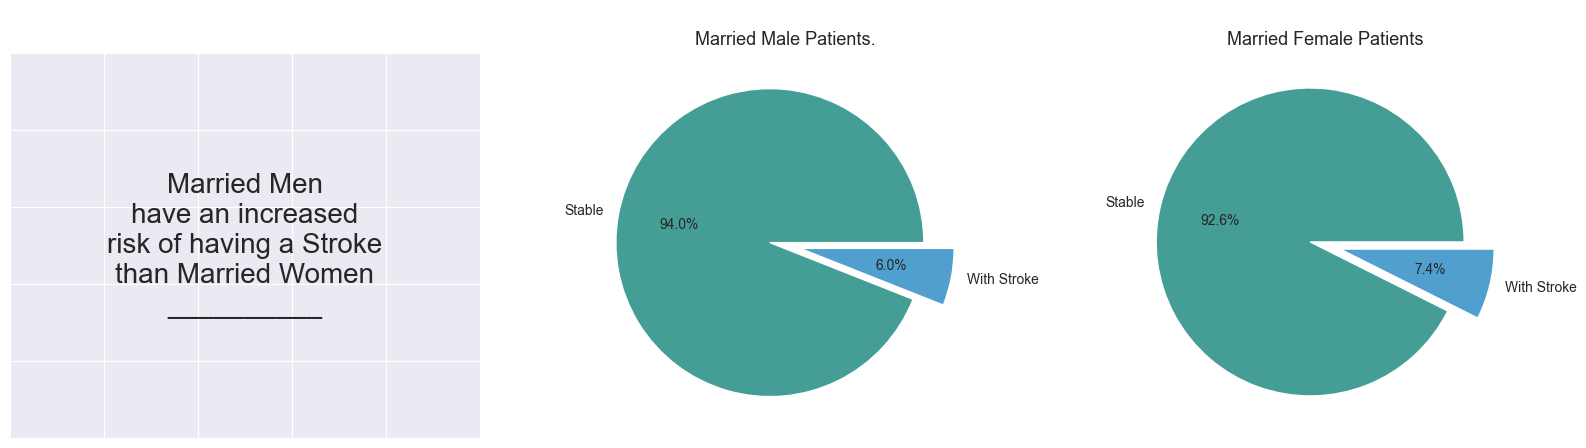

In [21]:
# Female
female = len(df_eda.loc[(df_eda['gender'] == 'Female') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 0)])
female_stroke =  len(df_eda.loc[(df_eda['gender'] == 'Female') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 1)])
female_total = len(df_eda.loc[(df_eda['gender'] == 'Female') & (df_eda['ever_married'] == 'Yes')])
female = round((female / female_total) * 100, 2)
female_stroke = round((female_stroke / female_total) * 100, 2)
patients_female = [female, female_stroke]

# Male
male = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 0)])
male_stroke =  len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 1)])
male_total = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes')])
male = round((male / male_total) * 100, 2)
male_stroke = round((male_stroke / male_total) * 100, 2)
patients_male = [male, male_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Married Men\nhave an increased\nrisk of having a Stroke\nthan Married Women\n__________',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_female, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nMarried Male Patients.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_male, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nMarried Female Patients", fontsize=13)

plt.show()

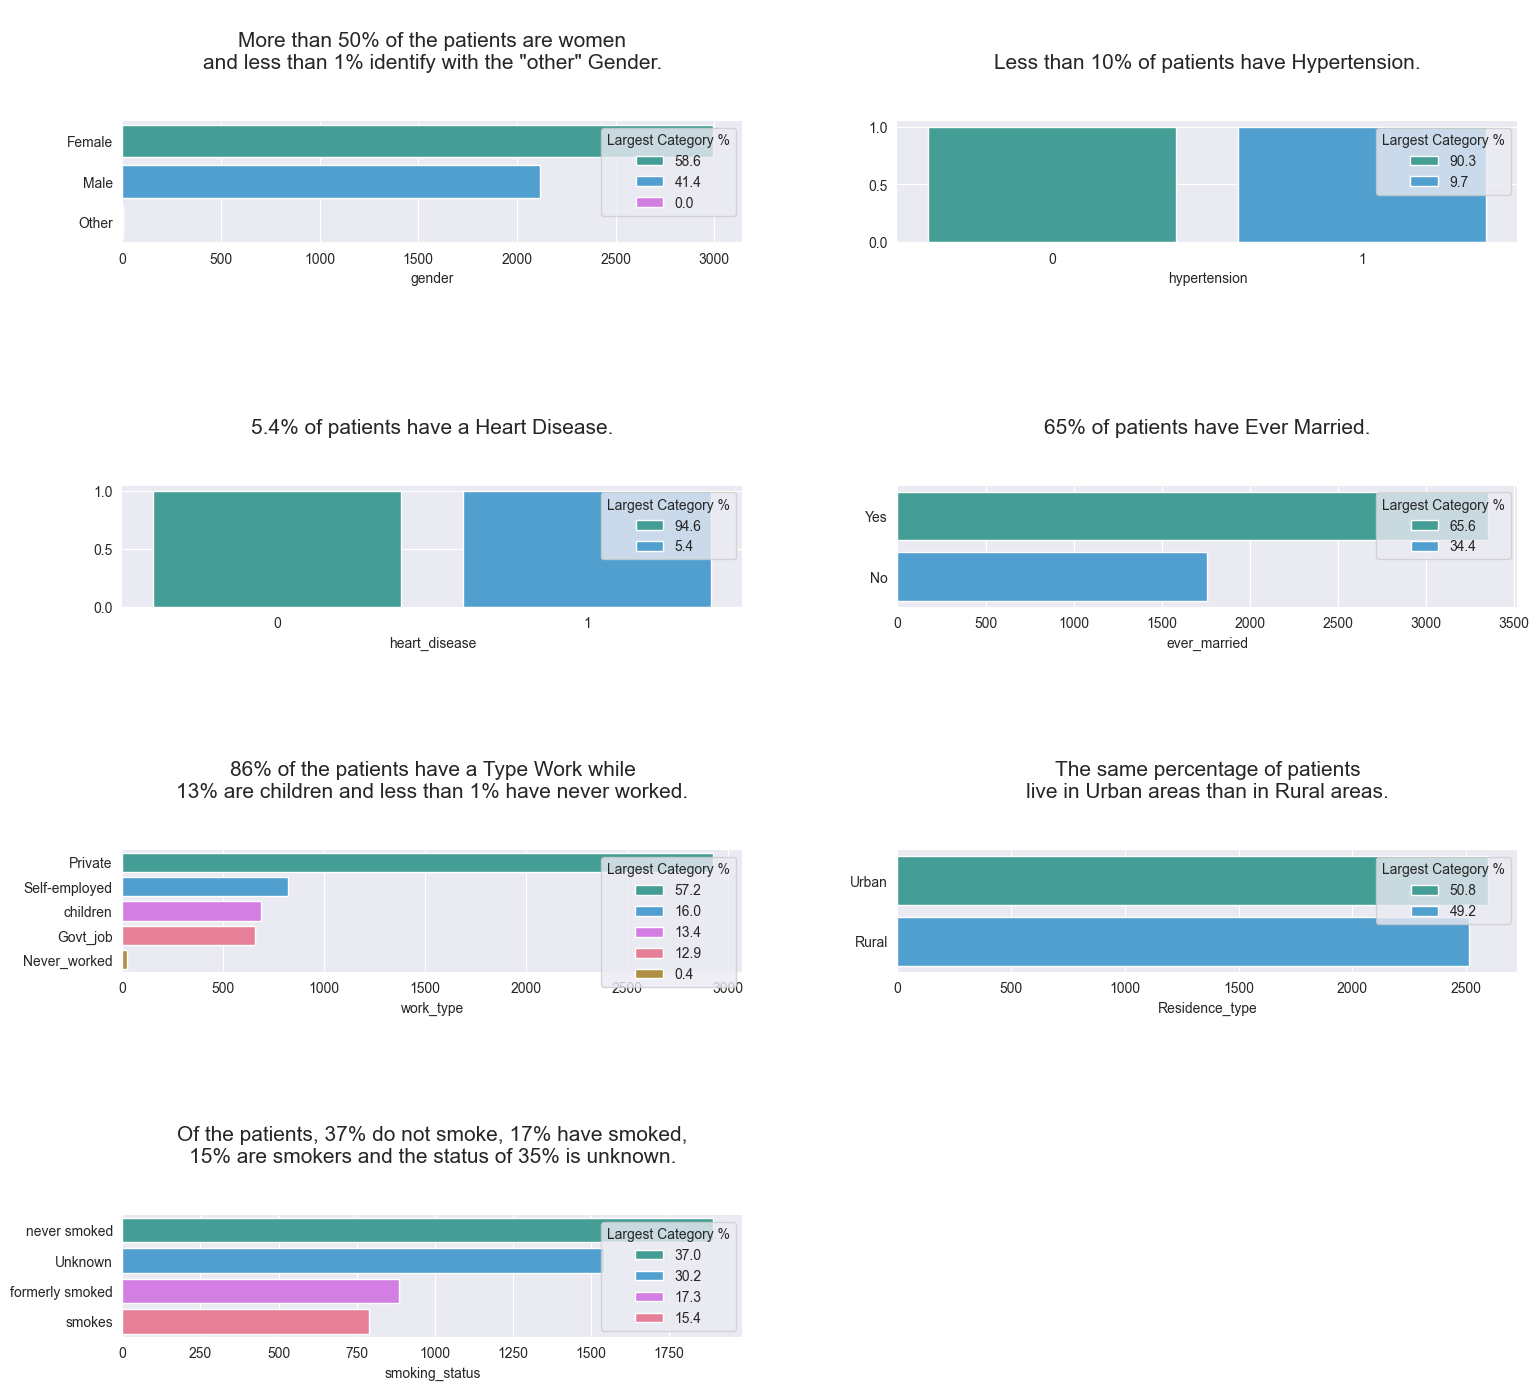

In [22]:
# Categorical Features (Delete Target Because it's a Features of Type "int64").
features_cat = df.select_dtypes(include=['object', 'int64']).columns
features_cat = features_cat.drop(['stroke'])


# Plot Description.
description = [str(f'\nMore than 50% of the patients are women\nand less than 1% identify with the "other" Gender.\n\n'),
               str(f'Less than 10% of patients have Hypertension.\n\n'),
               str(f'5.4% of patients have a Heart Disease.\n\n'),
               str(f'65% of patients have Ever Married.\n\n'),
               str(f'86% of the patients have a Type Work while\n13% are children and less than 1% have never worked.\n\n'),
               str(f'The same percentage of patients\nlive in Urban areas than in Rural areas.\n\n'),
               str(f'Of the patients, 37% do not smoke, 17% have smoked,\n15% are smokers and the status of 35% is unknown.\n\n')]

# Grid Plot.
fig = plt.figure(figsize=(18,30))
gs =  gridspec.GridSpec(7,2)
gs.update(wspace=0.25, hspace=2.0)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_cat.values):
    ax = plt.subplot(gs[i])
    sns.countplot(df[j], palette=palette, order=[x for x in df[j].value_counts().index])
    ax.set_title(description[i], fontsize=15)
    ax.legend([((x/len(df)*100).round(1)) for x in df[j].value_counts().values], title='Largest Category %')
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
plt.show()

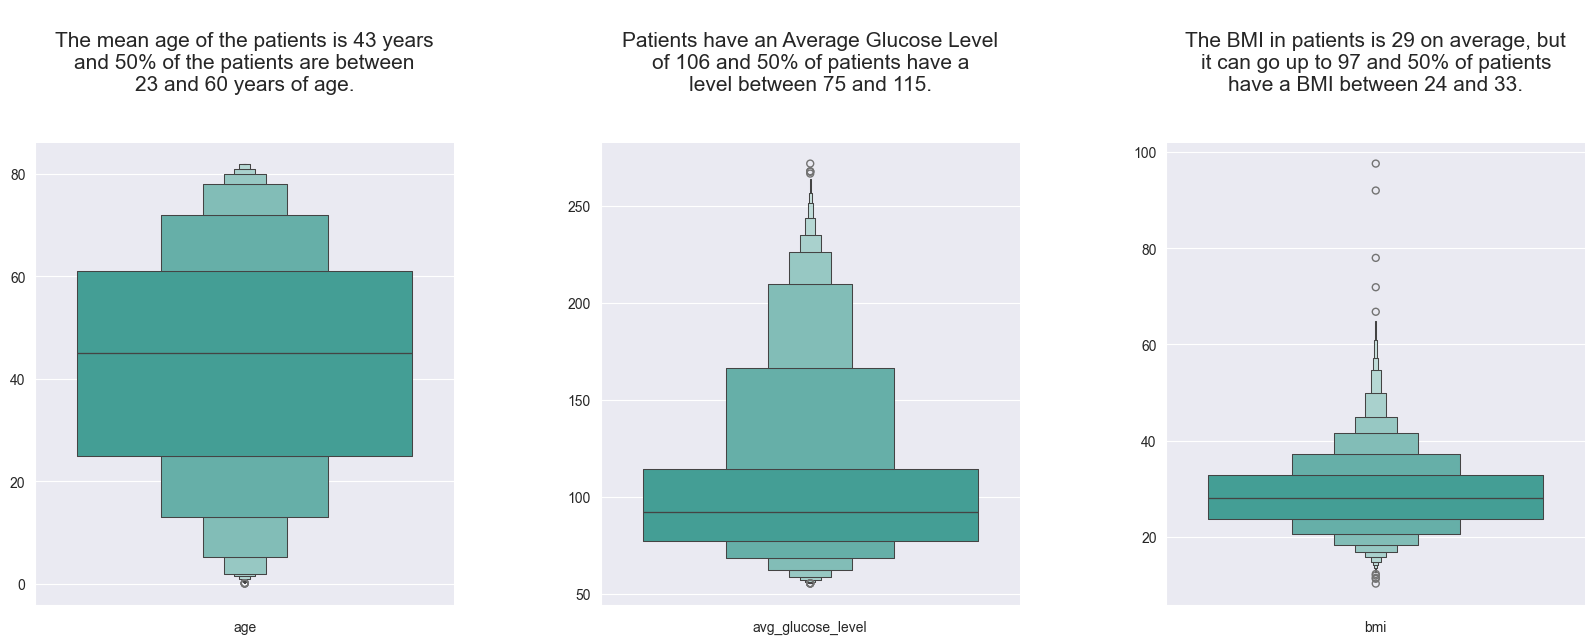

In [23]:
# Numerical Features.
features_num = df.select_dtypes(include='float64').columns

# Plot Description.
description = [str(f'\nThe mean age of the patients is 43 years\nand 50% of the patients are between\n23 and 60 years of age.\n\n'),
               str(f'Patients have an Average Glucose Level\nof 106 and 50% of patients have a\nlevel between 75 and 115.\n\n'),
               str(f'The BMI in patients is 29 on average, but\nit can go up to 97 and 50% of patients\nhave a BMI between 24 and 33.\n\n')]

# Grid Plot.
fig = plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(1,3)
gs.update(wspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_num.values):
    ax = plt.subplot(gs[i])
    sns.boxenplot(y=df[j], palette=palette)
    ax.set_title(description[i], fontsize=15)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
plt.show()

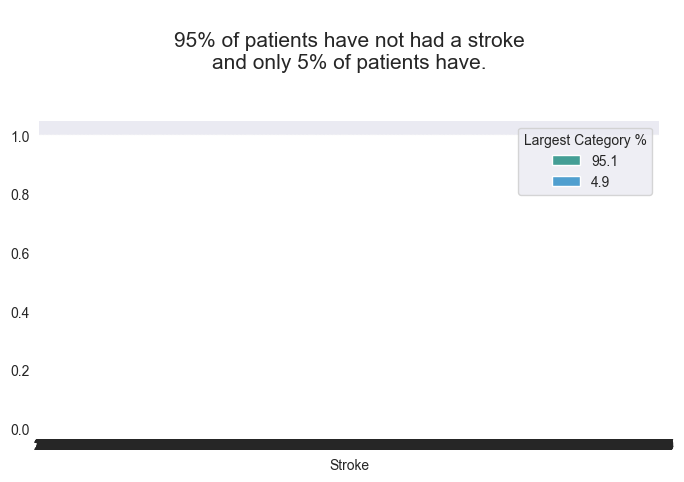

In [24]:
# Target.
target = df['stroke']

# Plot.
fig, ax = plt.subplots(figsize=(8, 4))
ax= sns.countplot(target, palette=palette)
ax.set_title(f"\n95% of patients have not had a stroke\nand only 5% of patients have.\n\n", fontsize=15)
ax.legend((target.value_counts()/len(df)*100).round(1), title='Largest Category %')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_xlabel('Stroke')
ax.set_ylabel('')
plt.show()

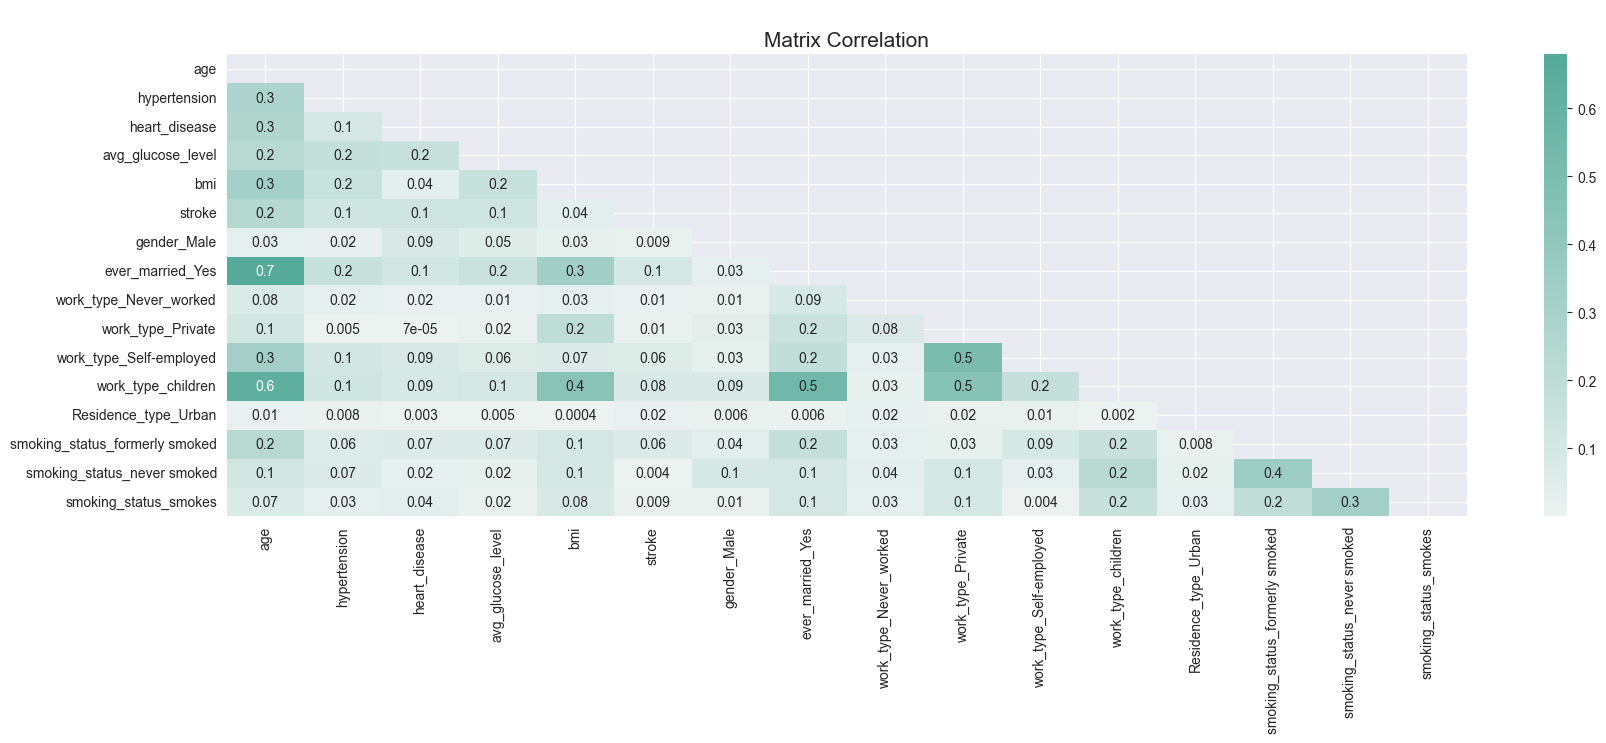

In [25]:
# DF Matrix Correlation.
df_corr = abs(df_encode.corr())

# Matrix Plot.
plt.subplots(figsize=(20,6))
sns.heatmap(df_corr, annot=True, fmt='.1g', cmap=palette_matrix, cbar=True, mask=np.triu(df_corr))
plt.title('\nMatrix Correlation', fontsize=15)
plt.show()

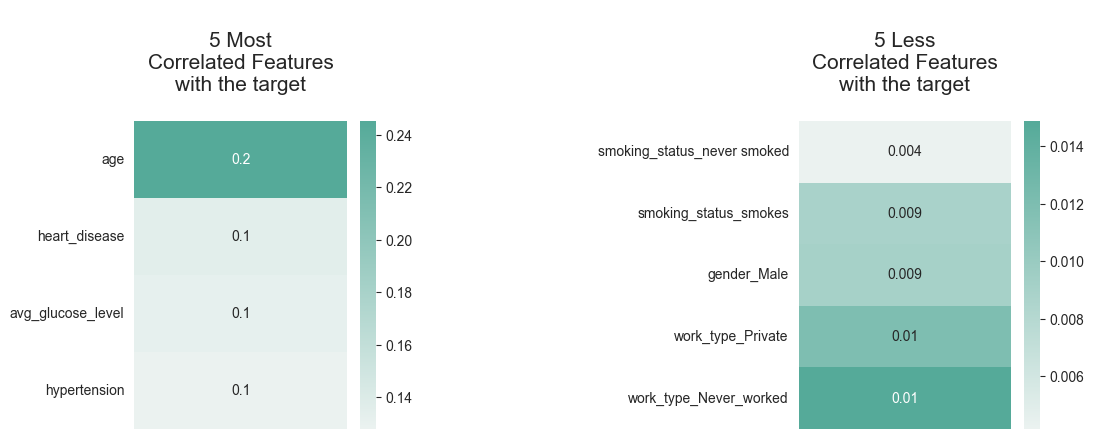

In [26]:
# DF with the features with the highest correlation and the target is removed.
corr_higher = pd.DataFrame(df_corr['stroke'].sort_values(ascending=False)).head()
corr_higher = corr_higher.drop('stroke', axis=0)

# DF with the features with less correlation.
corr_less = pd.DataFrame(df_corr['stroke'].sort_values()).head()

# List of DFs of Correlations
corr_ls = [corr_higher, corr_less]

# Plot Description.
description = [str(f'\n5 Most\nCorrelated Features\nwith the target\n'), str(f'5 Less\nCorrelated Features\nwith the target\n')]

# Grid Plot.
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace=1.5, hspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(corr_ls):
    ax = plt.subplot(gs[i])
    sns.heatmap(corr_ls[i], annot=True, fmt='.1g', cmap=palette_matrix, cbar=True)
    ax.set_title(description[i], fontsize=15)
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
plt.show()

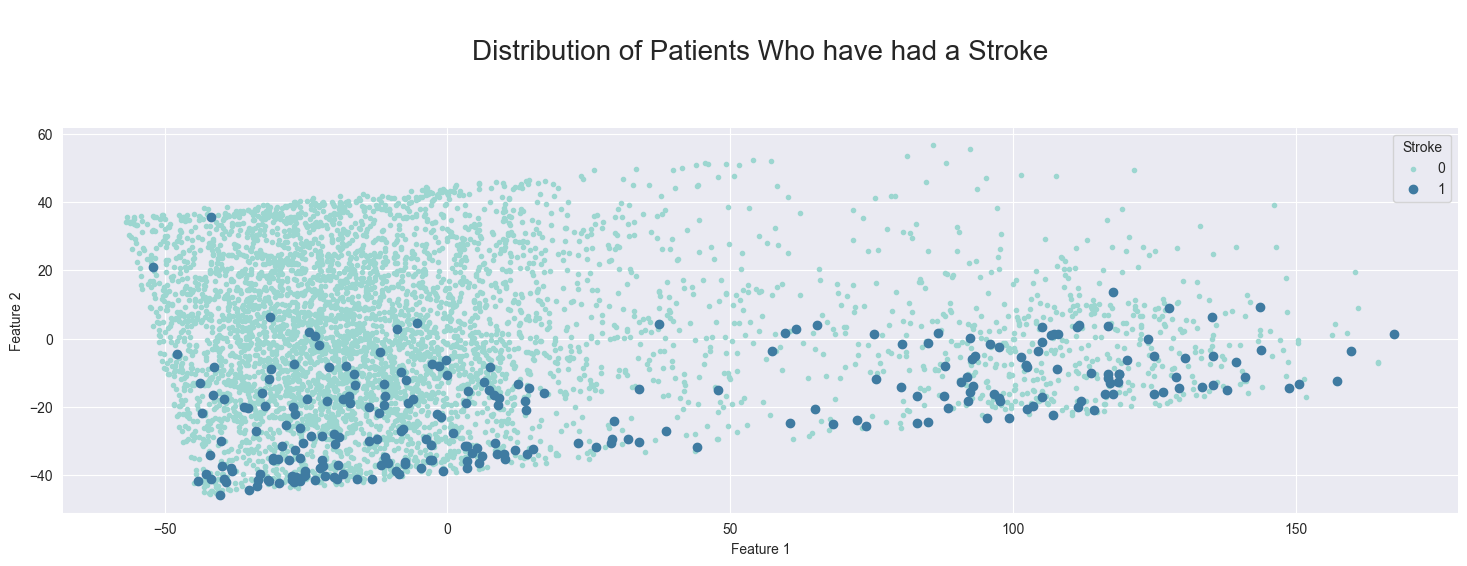

In [27]:
# Patients who have not had Stroke.
no_stroke = [df_reduce["feature_1"][df_reduce['stroke'] == 0], df_reduce["feature_2"][df_reduce['stroke'] == 0]]
# Patients who have had Stroke.
yes_stroke = [df_reduce["feature_1"][df_reduce['stroke'] == 1], df_reduce["feature_2"][df_reduce['stroke'] == 1]]

# Plot.
fig, ax = plt.subplots(figsize=(18, 5))
ax.scatter(no_stroke[0], no_stroke[1], c="#9CD6D0", marker=".") # Green
ax.scatter(yes_stroke[0], yes_stroke[1], c="#3F7BA1", marker="o") # Blue
ax.set_title(f"\nDistribution of Patients Who have had a Stroke\n\n", fontsize=20)
ax.legend(df['stroke'].value_counts().index, title="Stroke")
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

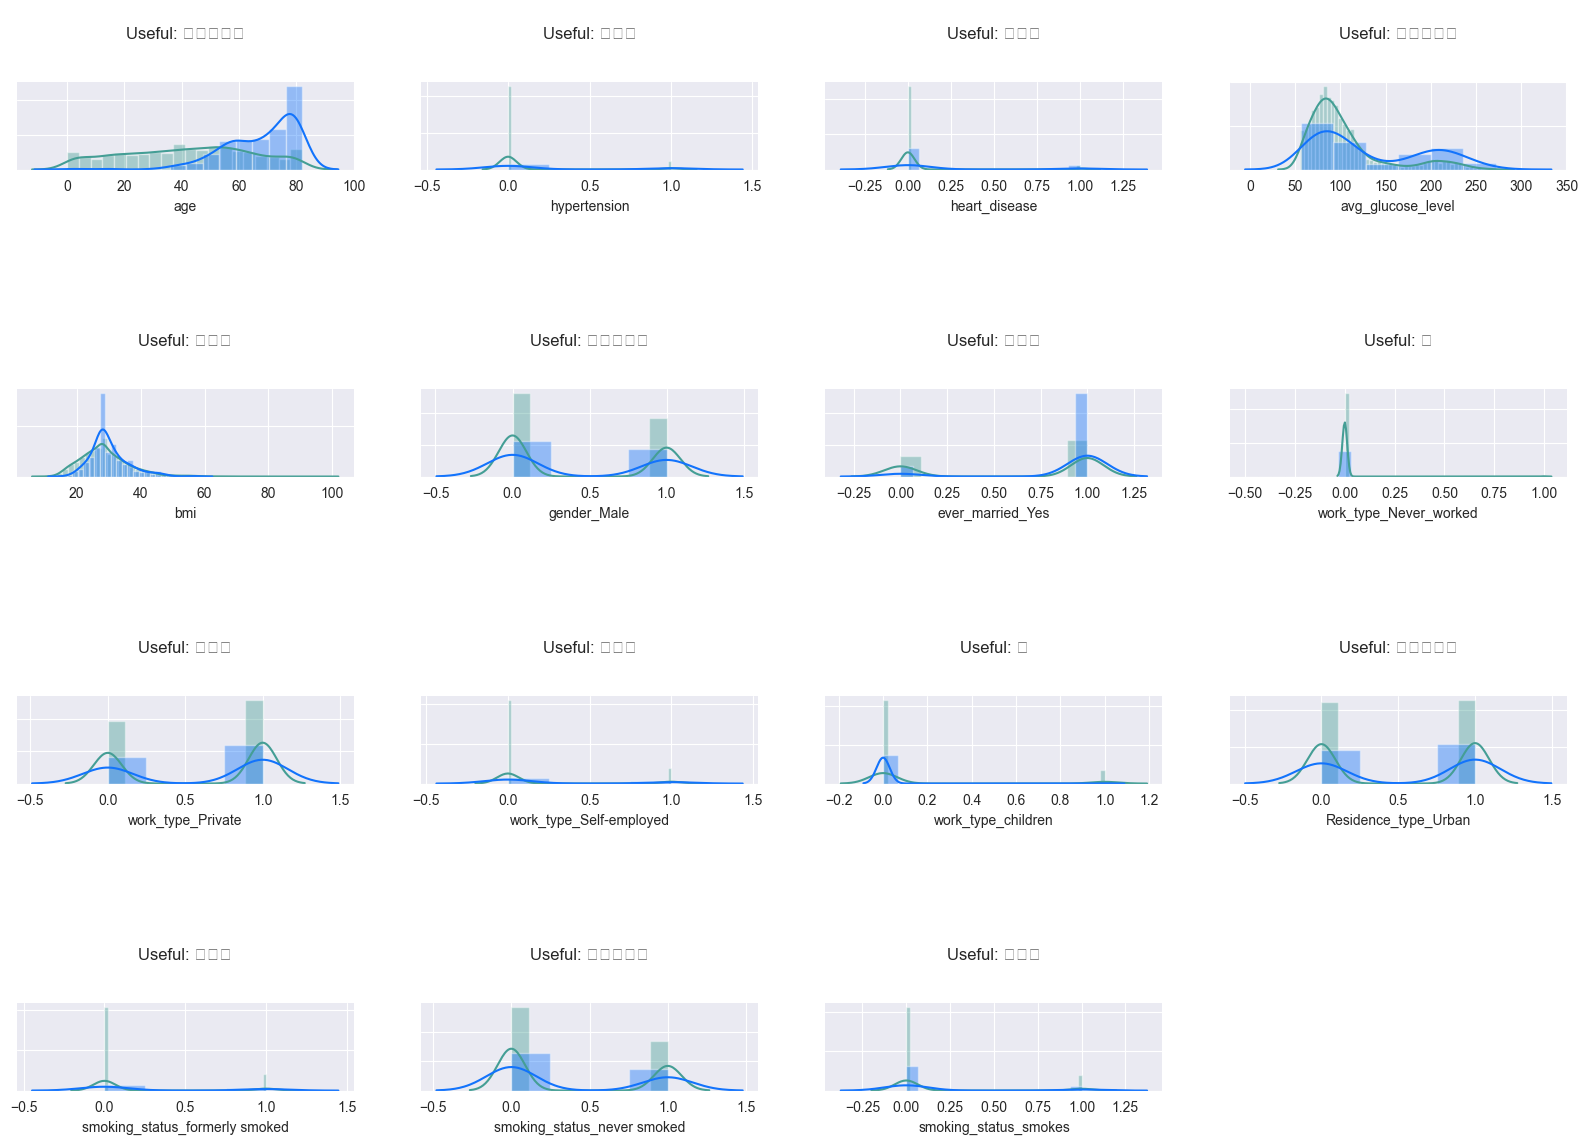

In [28]:
# Plot Description.
description = [str(f'\nUseful: ★★★★★\n\n'), str(f'Useful: ★★★\n\n'), str(f'Useful: ★★★\n\n'), str(f'Useful: ★★★★★\n\n'),
               str(f'Useful: ★★★\n\n'), str(f'Useful: ★★★★★\n\n'), str(f'Useful: ★★★\n\n'), str(f'Useful: ★\n\n'),
               str(f'Useful: ★★★\n\n'), str(f'Useful: ★★★\n\n'), str(f'Useful: ★\n\n'), str(f'Useful: ★★★★★\n\n'), str(f'Useful: ★★★\n\n'),
               str(f'Useful: ★★★★★\n\n'), str(f'Useful: ★★★\n\n')]

# Plot.
plt.figure(figsize=(20,45))
gs = gridspec.GridSpec(12,4)
gs.update(hspace=2.5, wspace=.2)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_encode):
    ax = plt.subplot(gs[i])
    sns.distplot(df_encode[j][df_encode['stroke']==0], color='#449E95') # Green
    sns.distplot(df_encode[j][df_encode['stroke']==1], color='#1273FC') # Blue
    ax.set_title(description[i], fontsize=12)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
    ax.tick_params(left=False)
    ax.set_yticklabels([])

plt.show()

In [29]:
# Remove of feature "id".
df_m = df_m.drop('id', axis=1)

# Remove Noisy Feature.
df_m = df_m.drop(df_m.loc[df_m['gender']=='Other'].index)

# Get the features of type object.
cat_obj = df_m.select_dtypes(include='object').columns

# Object type Features are Coded.
df_m = pd.get_dummies(df_m, columns=cat_obj, prefix_sep='_', drop_first=True)

# Imputer Data
df_m_values = KNNImputer(n_neighbors=4, weights="uniform").fit_transform(df_m)

# New DF
df_m = pd.DataFrame(df_m_values, columns=df_m.columns)

In [30]:
df_m

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0.0,1.0,228.69,36.60,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,61.0,0.0,0.0,202.21,34.10,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0.0,1.0,105.92,32.50,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0.0,0.0,171.23,34.40,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,79.0,1.0,0.0,174.12,24.00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,80.0,1.0,0.0,83.75,26.85,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5105,81.0,0.0,0.0,125.20,40.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5106,35.0,0.0,0.0,82.99,30.60,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5107,51.0,0.0,0.0,166.29,25.60,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
# DF to Standardize.
s_df_m = df_m.copy()

# The features for Standardize are obtained.
continuous_features = df_m.select_dtypes(include='float64').columns

# Standardized DF.
s_df_m[continuous_features] = RobustScaler().fit_transform(s_df_m[continuous_features])

# Show
s_df_m.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.611111,0.0,1.0,3.712619,0.893617,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.444444,0.0,0.0,2.994030,0.627660,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,1.0,0.0
2,0.972222,0.0,1.0,0.381004,0.457447,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0
3,0.111111,0.0,0.0,2.153324,0.659574,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.944444,1.0,0.0,2.231750,-0.446809,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,1.0,0.0


In [32]:
# Split the data (Auxiliary Function is used).

# .:: NORMAL MODEL ::.
train_set, val_set, test_set = train_val_test_split(df_m)
print("\n.:: Normal Model ::.")
print(f"Training Set Length: {len(train_set)}")
print(f"Validation Set Length: {len(val_set)}")
print(f"Test Set Length: {len(test_set)}")
 
# .:: STANDARDIZED MODEL ::.
s_train_set, s_val_set, s_test_set = train_val_test_split(s_df_m)
print("\n.:: Standardized Model ::.")
print(f"Training Set Length: {len(s_train_set)}")
print(f"Validation Set Length: {len(s_val_set)}")
print(f"Test Set Length: {len(s_test_set)}\n")


.:: Normal Model ::.
Training Set Length: 3065
Validation Set Length: 1022
Test Set Length: 1022

.:: Standardized Model ::.
Training Set Length: 3065
Validation Set Length: 1022
Test Set Length: 1022


In [33]:
# Separate features from target (Auxiliary Function is used).

# .:: NORMAL MODEL ::.
X_train, y_train = remove_labels(train_set, 'stroke')
X_val, y_val = remove_labels(val_set, 'stroke')
X_test, y_test = remove_labels(test_set, 'stroke')

# .:: STANDARDIZED MODEL ::.
s_X_train, s_y_train = remove_labels(s_train_set, 'stroke')
s_X_val, s_y_val = remove_labels(s_val_set, 'stroke')
s_X_test, s_y_test = remove_labels(s_test_set, 'stroke')

In [34]:
# The SMOTE transformer is instantiated to balance the data.
smote =  SMOTE(random_state=42)

# .:: NORMAL MODEL ::.
X_train, y_train = smote.fit_resample(X_train, y_train)
X_val, y_val = smote.fit_resample(X_val, y_val)
X_test, y_test = smote.fit_resample(X_test, y_test)

# .:: STANDARDIZED MODEL ::.
s_X_train, s_y_train = smote.fit_resample(s_X_train, s_y_train)
s_X_val, s_y_val = smote.fit_resample(s_X_val, s_y_val)
s_X_test, s_y_test = smote.fit_resample(s_X_test, s_y_test)

# Show Set Length
print(f"\nTrain Set:\n{y_train.value_counts()}\n\nValidation Set:\n{y_val.value_counts()}\n\nTest Set:\n{y_test.value_counts()}\n")


Train Set:
stroke
0.0    2930
1.0    2930
Name: count, dtype: int64

Validation Set:
stroke
0.0    972
1.0    972
Name: count, dtype: int64

Test Set:
stroke
0.0    958
1.0    958
Name: count, dtype: int64


In [35]:
# List of most important Features for a model (Auxiliary Function is used).
df_topF = top_features(X_train, y_train, s_X_train, s_y_train)
df_topF

,Features,Value,Features Standardized,Values S
0,age,0.308606,ever_married_Yes,0.220025
1,work_type_Self-employed,0.086624,age,0.186969
2,ever_married_Yes,0.086208,heart_disease,0.096823
3,hypertension,0.075215,smoking_status_formerly smoked,0.065394
4,smoking_status_never smoked,0.068791,bmi,0.065307
5,smoking_status_formerly smoked,0.066702,avg_glucose_level,0.057756
6,bmi,0.060273,work_type_Private,0.055747
7,smoking_status_smokes,0.059339,Residence_type_Urban,0.051087
8,Residence_type_Urban,0.050857,hypertension,0.048265
9,avg_glucose_level,0.050269,gender_Male,0.040352


In [36]:
# DFs are created with the best 8 features.
top_features = df_topF['Features'].head(8).values
X_train_topF = X_train[top_features].copy()
X_val_topF = X_val[top_features].copy()
X_test_topF = X_test[top_features].copy()

In [37]:
# Models Names.
c_names = ["Nearest Neighbors", "SVM Linear", "SVM RBF", "Gaussian NB", "Bernoulli NB", "QuadraticDA",
           "Stochastic GDC", "Decision Tree", "Random Forest", "NN MLP", "Ada Boost", "XGBC Boost", "Cat Boost"]

# Models.
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.010),
    SVC(gamma=2, C=1),
    GaussianNB(),
    BernoulliNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="elasticnet", max_iter=5),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    XGBClassifier(),
    CatBoostClassifier(logging_level='Silent')
]

In [38]:
# Top Models without Standarized (Auxiliary Function is used).
df_classifiers = search_model(c_names, classifiers, X_train, y_train, X_val, y_val, X_test, y_test, 1)
df_classifiers

,Ada Boost,Cat Boost,XGBC Boost,Random Forest,Bernoulli NB,Decision Tree,SVM Linear,NN MLP,Gaussian NB,Stochastic GDC,Nearest Neighbors,QuadraticDA,SVM RBF
F1 Vali,95.233,94.946,93.066,86.236,85.032,80.758,77.416,76.520,74.586,71.240,61.029,22.886,0.00
F1 Test,94.457,93.736,92.826,88.058,83.504,86.386,80.983,80.415,75.552,71.948,61.118,14.722,0.00
Fitting,0.777,1.210,0.240,-1.822,1.528,-5.628,-3.567,-3.895,-0.966,-0.708,-0.089,8.165,0.00
Seconds,0.472,3.775,1.094,0.026,0.003,0.022,2.750,0.850,0.003,0.005,0.015,0.005,8.67


In [39]:
# Top Model with Standarized (Auxiliary Function is used).
s_df_classifiers = search_model(c_names, classifiers, s_X_train, s_y_train, s_X_val, s_y_val, s_X_test, s_y_test, 1)
s_df_classifiers

,Cat Boost,XGBC Boost,Ada Boost,Random Forest,Bernoulli NB,Stochastic GDC,Decision Tree,SVM Linear,NN MLP,Gaussian NB,Nearest Neighbors,QuadraticDA,SVM RBF
F1 Vali,91.288,89.369,86.804,81.240,78.626,76.819,76.665,75.835,73.235,73.190,46.154,31.054,28.257
F1 Test,89.865,88.927,86.522,78.647,78.347,81.342,81.470,80.389,77.052,73.438,51.909,24.456,16.667
Fitting,1.423,0.442,0.282,2.594,0.279,-4.523,-4.805,-4.554,-3.817,-0.249,-5.756,6.598,11.591
Seconds,3.802,0.112,0.396,0.110,0.008,0.012,0.061,1.457,4.075,0.007,0.012,2.456,2.241


In [40]:
# The 3 best classifiers are selected.
classifiers_top3 = df_classifiers[['Ada Boost', 'Cat Boost', 'XGBC Boost']]

# Names are assigned, models are declared, and the search_model() function is applied
names_topF = ['Ada topF', 'Cat topF', 'XGBC topF']
classifiers_topF = [AdaBoostClassifier(), CatBoostClassifier(logging_level='Silent'), XGBClassifier()]
classifiers_topF = search_model(names_topF, classifiers_topF, X_train_topF, y_train, X_val_topF, y_val, X_test_topF, y_test, 1)

# A DF is created to compare the models with all the features vs the models with only the best 8 features.
comparison = pd.concat([classifiers_top3, classifiers_topF], axis=1)

# A column is created with the difference between the model types.
comparison['Ada Difference'] = comparison['Ada Boost'] - comparison['Ada topF']
comparison['Cat Difference'] = comparison['Cat Boost'] - comparison['Cat topF']
comparison['XGBC Difference'] = comparison['XGBC Boost'] - comparison['XGBC topF']

# The DF is organized.
comparison = comparison[['Ada Difference', 'Ada Boost', 'Ada topF',
                         'Cat Difference', 'Cat Boost', 'Cat topF',
                         'XGBC Difference', 'XGBC Boost', 'XGBC topF']]
comparison

,Ada Difference,Ada Boost,Ada topF,Cat Difference,Cat Boost,Cat topF,XGBC Difference,XGBC Boost,XGBC topF
F1 Vali,5.298,95.233,89.935,3.384,94.946,91.562,2.009,93.066,91.057
F1 Test,4.152,94.457,90.305,2.837,93.736,90.899,1.877,92.826,90.949
Fitting,1.147,0.777,-0.370,0.547,1.210,0.663,0.132,0.240,0.108
Seconds,0.123,0.472,0.349,-8.910,3.775,12.685,0.953,1.094,0.141


In [42]:
# The classifier is instantiated.
model = AdaBoostClassifier()

# The hyperparameters to test are declared.
param_grid = [{'base_estimator': [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=5)],
              'learning_rate': [0.25, 0.50, 0.75, 1.0, 1.25, 1.50],
              'algorithm': ["SAMME", "SAMME.R"]}]

# The search for the best hyperparameters is carried out and we train the model.
search_prmtrs = GridSearchCV(model, param_grid, cv=5, scoring='f1', return_train_score=True)
search_prmtrs.fit(X_train_topF, y_train)

print(f"\nF1 Score: {round(max(search_prmtrs.cv_results_['mean_test_score'])*100, 2)}% \nParameters: {search_prmtrs.best_params_}")


F1 Score: 94.95% 
Parameters: {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(max_depth=5), 'learning_rate': 1.25}


In [43]:
# The best model with the best hyperparameters is instantiated.
best_model = search_prmtrs.best_estimator_
best_model

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=1.25)

In [44]:
# It is validated that it does not overfit with the Validation Set.
y_val_pred = best_model.predict(X_val_topF)
print(f"\n.: Validation Set :. \nF1 Score: {round(f1_score(y_val, y_val_pred, pos_label=0)*100,2)}%")

# It is validated that it does not overfit with the Test Set.
y_test_pred = best_model.predict(X_test_topF)
print(f"\n.: Test Set :. \nF1 Score: {round(f1_score(y_test, y_test_pred, pos_label=0)*100,2)}%")


.: Validation Set :. 
F1 Score: 91.28%

.: Test Set :. 
F1 Score: 92.06%


In [45]:
# The model is saved.
dump(best_model, "stroke_model.joblib")

['stroke_model.joblib']

In [46]:
# The datasets are saved with the reduction in the features.
X_train_topF.to_csv('X_train.csv', index=False)
X_val_topF.to_csv('X_val.csv', index=False)
X_test_topF.to_csv('X_test.csv', index=False)

# Tags are saved.
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [47]:
# Load the model.
modelo = load('stroke_model.joblib')

# Test the model.
y_modelo_pred = modelo.predict(X_test_topF)
print('F1 Score: ', f1_score(y_modelo_pred, y_test, pos_label=0))

F1 Score:  0.9206190713929107


In [48]:
X_test_topF

,age,work_type_Self-employed,ever_married_Yes,hypertension,smoking_status_never smoked,smoking_status_formerly smoked,bmi,smoking_status_smokes
0,76.000000,1.000000,1.0,0.000000,1.000000,0.000000,31.800000,0.000000
1,42.000000,0.000000,1.0,0.000000,1.000000,0.000000,27.900000,0.000000
2,57.000000,0.000000,1.0,0.000000,0.000000,0.000000,19.400000,1.000000
3,41.000000,0.000000,1.0,0.000000,0.000000,0.000000,27.900000,0.000000
4,62.000000,0.000000,1.0,0.000000,0.000000,1.000000,36.000000,0.000000
...,...,...,...,...,...,...,...,...
1911,79.085658,0.085658,1.0,0.000000,1.000000,0.000000,24.140039,0.000000
1912,68.423237,0.000000,1.0,0.000000,0.000000,0.894191,32.061359,0.000000
1913,78.808133,0.000000,0.0,1.000000,0.191867,0.808133,22.626174,0.000000
1914,61.850573,0.000000,1.0,0.676628,0.000000,0.000000,40.715671,0.676628


In [59]:
# Load the model (if you haven't already)
model = load('stroke_model.joblib')

# Define the new instance data with the 8 selected features
new_instance = {
    'age': 21,
    'work_type_Self-employed': 0,
    'ever_married_Yes': 0,  # 1 = Yes, 0 = No
    'hypertension': 0,
    'smoking_status_never smoked': 0,  # Not never smoked
    'smoking_status_formerly smoked': 0,
    'bmi': 22.5,
    'smoking_status_smokes': 0,
    # 'avg_glucose_level': 120.5,
    # 'gender_Male': 1,  # Male
    # 'work_type_Private': 1,  # Private
    # 'work_type_children': 0,  # Not children
    # 'residence_type_Urban': 1,  # Urban
}

# Convert the new instance to a DataFrame
new_data = pd.DataFrame([new_instance])

# Apply the model to make a prediction
prediction = model.predict_proba(new_data)[0][1] * 100

# Print the prediction
print(f"Probability of having a stroke: {prediction:.2f}%")

Probability of having a stroke: 35.46%
